# Climate Change Data Analysis

The goal of this project is to explore land temperature data in different areas over time, to assess the severity of climate change.

In [1]:
import pickle
import os
import sys
import pandas as pd
import numpy as np
import copy

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

%reload_ext autoreload
%autoreload 2

In [2]:
# Load data

with open('data/GlobalLandTemperaturesByCity.csv', 'r') as f:
    city_data = pd.read_csv(f)

## Data Cleaning

First we'll investigate the various variables in the data and do some cleaning.

In [4]:
city_data.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   
2  1744-01-01                 NaN                            NaN  Århus   
3  1744-02-01                 NaN                            NaN  Århus   
4  1744-03-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E

In [5]:
city_data.shape

(8599212, 7)

In [12]:
city_data.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

The data is pretty self-explanatory - we have average temperatures with uncertainty for cities over time. We can convert the time column into datetime objects and parse the latitude and longitude (remove the direction and multiply by -1 for S and W)

In [6]:
city_data['time'] = pd.to_datetime(city_data['dt'], format='%Y-%m-%d')

In [33]:
'34.56S'.split('N')

['34.56S']

In [4]:
def parse_lat_lon(val, t):
    if t == 'lat':
        if 'N' in val:
            return float(val.split('N')[0])
        elif 'S' in val:
            return -1 * float(val.split('S')[0])
        else:
            return np.nan
    else:
        if 'E' in val:
            return float(val.split('E')[0])
        elif 'W' in val:
            return -1 * float(val.split('W')[0])
        else:
            return np.nan
            

In [5]:
city_data['Latitude'] = map(lambda x: parse_lat_lon(x, 'lat'),city_data['Latitude'])
city_data['Longitude'] = map(lambda x: parse_lat_lon(x, 'lon'),city_data['Longitude'])

## Data Exploration

Now we'll look into the data further. Looking at the number of cities and countires, we get the following:

In [7]:
cities = np.unique(city_data['City'])
countries = np.unique(city_data['Country'])

In [15]:
print 'Number of unique cities: ' + str(len(cities))
print 'Number of unique countries: ' + str(len(countries))

Number of unique cities: 3448
Number of unique countries: 159


We'll look at the distribution of cities on a map:

In [12]:
unique_city_data = city_data.groupby('City').first()

In [ ]:
mpis = [{'lat': unique_city_data['Latitude'],
  'lon': unique_city_data['Longitude'],
  'marker': {'color': 'rgb(0,116,217)',
   'line': {'color': 'rgb(40,40,40)', 'width': 0.5},
   'size': 5,
   'sizemode': 'diameter'},
  'text': unique_city_data.index,
  'type': 'scattergeo'},
]


layout = go.Layout(
    title = 'City Distribution',
    showlegend = True,
    geo = dict(
            scope='world',
            projection=dict( type = 'natural earth'),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),)

fig =  go.Figure(layout=layout, data=mpis)
iplot( fig, validate=False)

Now we look at the amount of temperature data we have for each city - i.e. the distribution of the start year, and average sampling interval.

In [8]:
st_year = city_data.groupby('City').apply(lambda x: min(x.loc[x.loc[:,'AverageTemperature'].notnull(), 'time']).year)
ave_samp_rate = city_data.groupby('City').apply(lambda x: x.loc[x.loc[:, 'AverageTemperature'].notnull(), 'time'].diff().mean().total_seconds() / 3600.0)
end_year = city_data.groupby('City').apply(lambda x: max(x.loc[x.loc[:,'AverageTemperature'].notnull(), 'time']).year)
num_missing = city_data.groupby('City').apply(lambda x: sum(x.loc[:,'AverageTemperature'].isnull()))

In [11]:
temp = map(lambda x: x.year, city_data.loc[city_data.loc[:,'AverageTemperature'].isnull(), 'time'])

In [16]:
import random
iplot([go.Histogram(x = random.sample(temp, 2000))])

In [17]:
len(temp) * 100.0 / city_data.shape[0]

4.234457761943768

In [9]:
data_stats = pd.concat([st_year, end_year, ave_samp_rate, num_missing], 1)
data_stats.columns = ['start_year', 'end_year', 'ave_samp_interval', 'num_missing_vals']
data_stats

start_year  end_year  ave_samp_interval  num_missing_vals
City                                                                    
A Coruña             1743      2013         747.101422                73
Aachen               1743      2013         747.101422                73
Aalborg              1743      2013         747.101422                73
Aba                  1856      2013         796.622837               158
Abadan               1820      2013         816.115774               244
Abakaliki            1856      2013         796.622837               158
Abakan               1820      2013         730.487047                 1
Abbotsford           1828      2013         746.233838                47
Abengourou           1849      2013         782.368764               132
Abeokuta             1856      2013         803.106977               172
Aberdeen             1743      2013         747.101422                73
Abha                 1861      2013         733.276316                 8
Abidjan              1849      2013         812.324324               200
Abiko                1845      2013         731.922734                 5
Abilene              1820      2013         730.806715                 1
Abohar               1816      2013         831.193084               288
Abomey Calavi        1849      2013         820.175099               217
Abu Dhabi            1843      2013         788.658228               152
Abuja                1856      2013         803.106977               172
Acapulco             1843      2013         754.860606                66
Acarigua             1824      2013         797.053237               191
Accra                1849      2013         815.077966               206
Achalpur             1796      2013         760.781811               105
Acheng               1820      2013         730.487047                 1
Achinsk              1820      2013         730.487047                 1
Acuña                1823      2013         735.333333                15
Adana                1791      2013         731.589936                 5
Addis Abeba          1850      2013         854.545888               286
Adelaide             1841      2013         732.243950                 6
Aden                 1876      2013         733.591241                 8
...                   ...       ...                ...               ...
Zhicheng             1840      2013         731.191530                 3
Zhongshan            1840      2013         730.484878                 1
Zhoucheng            1816      2013         778.822682               148
Zhoucun              1840      2013         730.484878                 1
Zhoukou              1841      2013         730.476099                 1
Zhucheng             1841      2013         730.476099                 1
Zhuhai               1840      2013         730.484878                 1
Zhuji                1841      2013         730.476099                 1
Zhukovskiy           1743      2013         747.101422                73
Zhumadian            1841      2013         730.476099                 1
Zhuozhou             1820      2013         734.610508                14
Zhuzhou              1841      2013         730.828986                 2
Zhytomyr             1743      2013         747.101422                73
Zielona Gora         1743      2013         747.101422                73
Zigong               1820      2013         774.992213               134
Ziguinchor           1849      2013         771.490909               106
Zinder               1856      2013         803.106977               172
Zlatoust             1779      2013         796.656299               234
Zoetermeer           1743      2013         747.101422                73
Zonguldak            1743      2013         753.769844               101
Zouxian              1840      2013         730.484878                 1
Zunyi                1840      2013         730.484878                 1


In [22]:
print 'Number of unique start years: ' + str(len(np.unique(data_stats['start_year'])))
print 'Number of unique end years: ' + str(len(np.unique(data_stats['end_year'])))

Number of unique start years: 65
Number of unique end years: 1


All data collection appears to end in the same year:

In [24]:
print data_stats['end_year'].iloc[0]

2013


Below we plot histograms for the start year, number of samples and average sampling rate:

In [25]:
iplot(go.Figure(data = [go.Histogram(x = data_stats['start_year'])],
               layout = go.Layout(title = 'Distribution of Start Year of Temp Samples')))

In [66]:
iplot(go.Figure(data = [go.Histogram(x = data_stats['num_samps'])],
               layout = go.Layout(title = 'Distribution of Number of Temp Samples per City')))

In [18]:
iplot(go.Figure(data = [go.Histogram(x = data_stats['ave_samp_interval'])],
               layout = go.Layout(title = 'Distribution of Average Sampling Interval (Hours)')))

The data collection beings for each city somewhere in the 1700s or 1800s and ends in 2013.  The vast majority of cities were sampled about one a month (~730 hours), some had higher sampling rates but not lower than once a month.  Thus, the majority of cities had about 2000-3000 total temperature samples and the cities with higher sampling rates had up to 9000 samples.

This is good since we'll be able to get temperature trends over 200 or so years and likely be able to remove seasonal variations. In addition, we can get these trends for many cities around the world and compare them.

Given this, we can refine our goal for this analysis to be to assess the rate of change of temperature over the last 200 years for cities around the world and the planet as a whole.  We will also attempt to predict the year where temperatures will hit 2C and 4C above pre-industrial levels.  

**Insert info about why 2C and 4C chosen**

## Trend Analysis

Now we'll investigate any trends present in the temperature data.  First we'll plot the temperature over time for a few cities around the world.  This paper: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.491.295&rep=rep1&type=pdf identifies a representative major city for each climate type:

Singapore (tropical) 
Cairo, Egypt (hot-arid)
Milan, Italy (temperate)
Fort Smith, Canada (cold)
Resolute (polar)

We don't have info for Fort Smith and Resolute - and in fact no information for any polar areas.  So we'll just look at Norilsk, Russia for a cold climate, even though the climate is actually both cold and temperate (https://en.climate-data.org/asia/russian-federation/krasnoyarsk-krai/norilsk-1831/)  Also I'll add Ottawa, Canada since that's my lovely home town! According to Wikipedia, it has a cold AND temperate climate.  Gotta love those extremes.

We'll also add the trend line by applying a moving average to the data for each city. I used a window size of 1 year to help remove the seasonality from the data.


In [39]:
samp_c = ['Singapore', 'Cairo', 'Milan', 'Norilsk', 'Ottawa']

In [210]:
trends = city_data.loc[[x in samp_c for x in city_data['City']], 
                        ['time', 'AverageTemperature']].groupby(city_data['City'], 
                                                                as_index = False).rolling(window = '3600d', on = 'time').mean()
trends['city'] =list(city_data.loc[[x in samp_c for x in city_data['City']], 'City'])
trends.reset_index(inplace = True)

In [195]:
def plot_city_temp_trend(city_data, trend_data, c):
    data = city_data.loc[city_data['City'] == c,:]
    return go.Figure(data = [go.Scatter(x = data['time'], y = data['AverageTemperature']), 
                            go.Scatter(x = trends.loc[trends['city'] == c,'time'], 
                                       y = trends.loc[trends['city'] == c,'AverageTemperature'])], 
                    layout = go.Layout(title = 'Temperature of ' + c + ' Over Time'))

In [211]:
iplot(plot_city_temp_trend(city_data, trends, 'Singapore'))

In [197]:
iplot(plot_city_temp_trend(city_data, trends, 'Cairo'))

In [198]:
iplot(plot_city_temp_trend(city_data, trends, 'Milan'))

In [199]:
iplot(plot_city_temp_trend(city_data, trends, 'Norilsk'))

In [200]:
iplot(plot_city_temp_trend(city_data, trends, 'Ottawa'))

## Missing Data

There are chunks of missing data in the earlier years, so we'll delete the data before those chunks.  We'll also impute any isolating missing data points using

In [212]:
miss_samps = []
for ind, g in trends.groupby('city'):
    n = g['AverageTemperature'].isnull()
    miss_inds = np.where(np.diff(n))[0]
    miss_inds = zip(miss_inds[::2], miss_inds[1::2])
    df = pd.DataFrame([{'st_datetime': g['time'].iloc[x[0]],
                        'end_datetime': g['time'].iloc[x[-1]],
     'duration': (g['time'].iloc[x[1]] - g['time'].iloc[x[0]])}
                   for x in miss_inds])
    df['city'] = ind
    miss_samps.append(df)
miss_samps = pd.concat(miss_samps, sort = False)
miss_samps.reset_index(inplace = True)
miss_samps.drop('index', axis = 1, inplace = True)
miss_samps

city  duration        end_datetime         st_datetime
0  Singapore 1247 days 1839-03-01 00:00:00 1835-10-01 00:00:00

In [129]:
# Remove data up to start of continuous data
for x in zip(['Milan', 'Ottawa', 'Singapore'], [0, 1, 3]):
    trends.drop(trends.loc[(trends['time'] <= miss_samps.loc[x[1], 'end_datetime']) & (trends['city'] == x[0])].index,
               inplace = True)

In [213]:
for x in zip(['Singapore'], [0]):
    trends.drop(trends.loc[(trends['time'] <= miss_samps.loc[x[1], 'end_datetime']) & (trends['city'] == x[0])].index,
               inplace = True)

In [131]:
# Impute those isolating missing values for Singapore using interpolate
trends.interpolate(inplace = True)

We'll also delete data from before 1850, since that's approimately the point where the industrial revolution really got started and when scientists believe the warming began. Also that gives the same number of points for each city.

http://theconversation.com/why-is-climate-changes-2-degrees-celsius-of-warming-limit-so-important-82058

In [214]:
trends = trends.loc[trends['time'] >= pd.datetime(1850, 1, 1)]

In [215]:
iplot([go.Scatter(x = g['time'], y = g['AverageTemperature'], name = ind) for ind,g in trends.groupby('city')])

## Forcasting


In [216]:
df = trends.loc[trends['city'] == 'Ottawa',:]
n = np.polyfit(range(df.shape[0]), df['AverageTemperature'], deg = 5, full = True)

In [217]:
p = np.poly1d(n[0])
fit_vals = [p(i)  for i in range(df.shape[0])]
resid = [df['AverageTemperature'].iloc[i] - p(i)  for i in range(df.shape[0])]

In [218]:
iplot([go.Scatter(x = trends.loc[trends['city'] == 'Ottawa','time'], 
                  y = trends.loc[trends['city'] == 'Ottawa','AverageTemperature'], name = ind),
      go.Scatter(x = trends.loc[trends['city'] == 'Ottawa','time'], y = fit_vals)])

In [209]:
iplot([go.Scatter(x = fit_vals, y = resid, mode = 'markers')])

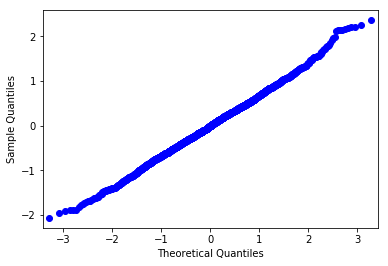

In [193]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

qqplot(np.array(resid))

In [181]:
print p(0), p(1964 + 12)

3.16121824425 5.1577535378


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X_train = [[1,2],[2,4],[6,7]]
y_train = [1.2, 4.5, 6.7]
X_test = [[1,3],[2,5]]    

# create a Linear Regressor   
lin_regressor = LinearRegression()

# pass the order of your polynomial here  
poly = PolynomialFeatures(2)

# convert to be used further to linear regression
X_transform = poly.fit_transform(X_train)

# fit this to Linear Regressor
lin_regressor.fit(X_transform,y_train) 

# get the predictions
y_preds = lin_regressor.predict(X_test)

In [ ]:
# Extract trend for all cities
# Impute missing values likely using splines but only for max interval of missing values
# Examine where in time the large chunks of missing data are
# Remove old data and data prior to large chunks of missing data
# Train a recurrent neural net on train set and test with test set
# Make predictions once a year for the next 50 years
# Find where each city hits the point of no return 2C above the temp in that city pre-industry (1800)
# Also find for 4C